In [47]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [48]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
import csv
import os
import pandas as pd
import scipy.io as spio
import numpy as np
from __future__ import division
import h5py
from pandas.stats.api import ols

from sklearn import linear_model, metrics, cross_validation
from sklearn.cross_validation import LeaveOneOut, train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import zero_one_loss

import itertools

In [2]:
#read in electrode clusters
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
PCAdir = os.path.join(SJdir, 'PCA')

filename = 'groupidx_hclust.csv'
filename = os.path.join(PCAdir, 'hclust', filename)
df = pd.DataFrame.from_csv(filename,index_col = [0], parse_dates = False)

In [3]:
#get list of subjects/task (those with recons)
reconlist = '/home/knight/matar/MATLAB/DATA/Avgusta/PCA/reconlist.csv'
reconlist = pd.read_csv(reconlist)

In [91]:
for x, c in enumerate(active.groupby('group')): #active elecs per cluster
    continue
    c = c[1].values
    cidx = np.in1d(active_elecs, c)
c[1].active_elec.values
x+1

6

##Plot single trials for each cluster

In [4]:
#plot single trials for each cluster
datadir = os.path.join(SJdir, 'Subjs')

savedir = os.path.join(PCAdir, 'SingleTrials_hclust')

for i,x in enumerate(reconlist.values[[43,44,45,46,47,48]]):
        
    subj_task, recon, xycoords,srate, _ = x
    subj, task = subj_task.split('_')
    
    if isinstance(recon, float):
        continue
    
    filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
    data = spio.loadmat(filename, struct_as_record = True)
    active_elecs = data['active_elecs'].squeeze()
    RTs = data['RTs'].squeeze()
    srate = data['srate']
    HGdata = data['data_percent']
    
    #cluster = df['group'][subj][task]
    #active = df['active_elec'][subj][task]
    active = df.loc[(df.subj==subj)&(df.task == task)][['active_elec', 'group']]
    
    #for x, c in enumerate(active.groupby(cluster)): #active elecs per cluster
    for c in active.groupby('group'): #active elecs per cluster
        g = c[0]
        c = c[1].active_elec.values
        cidx = np.in1d(active_elecs, c)
        cdata = HGdata[cidx,:,:]
        cdata = np.vstack([item for item in cdata]) #same thing as cdata.reshape([-1,2783]); gives you trials x time        
        
        RTs_all = tile(RTs, len(c)) #repmat RTs and sort (changed to sum(cidx) from len(c))
        
        ridx = RTs_all.argsort(axis=0) 
        RTs_all = RTs_all[ridx]
        
        cdata = cdata[ridx,:] #trials sorted by RTs
        
        #save data
        #filename = os.path.join(savedir, ''.join([subj_task, '_c', str(x+1)])) #save on cluster
        filename = os.path.join(savedir, ''.join([subj_task, '_c', str(g)])) #save on cluster
        spio.savemat(filename, mdict={'cdata': cdata, 'RTs_all': RTs_all, 'srate': srate, 'active_elecs': active.active_elec.values})
            
        #plot
        f,ax = plt.subplots()
        plt.title(' '.join(['cluster:', str(g), ', elecs:', str(c)]))
        ax.autoscale(enable = True, tight = True)
        cax = ax.pcolormesh(np.arange(-500, cdata.shape[1]-500), np.arange(0, len(ridx)), cdata, zorder = 0)
        cbar = f.colorbar(cax, ticks = [-150, 0 , 150], orientation = 'vertical')
        cax.set_clim(vmin=-150,vmax=150)

        for j in np.arange(len(RTs_all)):
            ax.plot((RTs_all[j], RTs_all[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)
 
        filename = os.path.join(savedir, ''.join([subj_task, '_c', str(g), '.png']))
        plt.savefig(filename)  
        plt.close()   

In [96]:
mdict={'cdata': cdata, 'RTs_all': RTs_all, 'srate': srate, 'active_elecs': active}
active.active_elec.values

array([  5,  14,  15,  27,  28,  29,  30,  33,  34,  35,  36,  37,  39,
        40,  41,  42,  43,  44,  45,  51,  55,  63,  74,  78,  79,  80,
        83,  84,  94,  99, 102, 103, 106])

## plot single trial for one electrode
#### edited for misses/empty

In [44]:
data.shape

(63, 4751)

"    \n#use axes with 0 shift, but shift RTs by 500 (should be same as above)\n#RTs_all = RTs_all+500\nf,ax = plt.subplots()\nax.autoscale(enable = True, tight = True)\n#cax = ax.pcolormesh(np.arange(0, data.shape[1]), np.arange(0, len(ridx)), data[ridx,:], zorder = 0)\ncax = ax.pcolormesh(np.arange(0, data.shape[1]), np.arange(0, data.shape[0]), data, zorder = 0)\n\ncbar = f.colorbar(cax, ticks = [-150, 0 , 150], orientation = 'vertical')\ncax.set_clim(vmin=-150,vmax=150)\n\n#for j in np.arange(len(RTs_all)):\n#    ax.plot((RTs_all[j], RTs_all[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)\n"

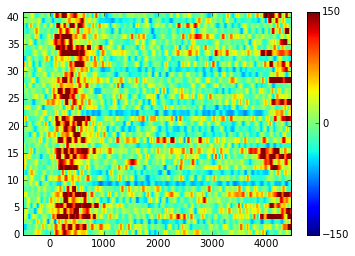

In [51]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
datadir = os.path.join(SJdir, 'Subjs')

subj = 'GP15'
task = 'EmoGen'
filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent_empty.mat')
data = spio.loadmat(filename, struct_as_record = True)
active_elecs = data['active_elecs'].squeeze()
RTs = data['RTs'].squeeze()
srate = data['srate']
HGdata = data['data_percent']

data = HGdata[np.where(active_elecs == 53),:,:]
data = data.squeeze()

#sort RTs
#ridx = RTs.argsort(axis=0) 
#RTs_all = RTs[ridx]

#using RTs calculated from stim onset, but with -500 axes
f,ax = plt.subplots()
ax.autoscale(enable = True, tight = True)
#cax = ax.pcolormesh(np.arange(-500, data.shape[1]-500), np.arange(0, len(ridx)), data[ridx,:], zorder = 0)
cax = ax.pcolormesh(np.arange(-500, data.shape[1]-500), np.arange(0, data.shape[0]), data)
cbar = f.colorbar(cax, ticks = [-150, 0 , 150], orientation = 'vertical')
cax.set_clim(vmin=-150,vmax=150)

#for j in np.arange(len(RTs_all)):
#    ax.plot((RTs_all[j], RTs_all[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)

'''    
#use axes with 0 shift, but shift RTs by 500 (should be same as above)
#RTs_all = RTs_all+500
f,ax = plt.subplots()
ax.autoscale(enable = True, tight = True)
#cax = ax.pcolormesh(np.arange(0, data.shape[1]), np.arange(0, len(ridx)), data[ridx,:], zorder = 0)
cax = ax.pcolormesh(np.arange(0, data.shape[1]), np.arange(0, data.shape[0]), data, zorder = 0)

cbar = f.colorbar(cax, ticks = [-150, 0 , 150], orientation = 'vertical')
cax.set_clim(vmin=-150,vmax=150)

#for j in np.arange(len(RTs_all)):
#    ax.plot((RTs_all[j], RTs_all[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)
'''

# No longer used (MATLAB) - now running using duration.ipynb

####Create csv with duration value (R, p) for each cluster</b>
####after running duration_avgusta_m2_clusters.m</i>

In [7]:
import glob
Rvals = list(); pvals = list(); subjs = list(); tasks = list(); clusters = list()
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
sigvalues = glob.glob(os.path.join(SJdir, 'PCA','duration_hclust','*sigvalues.mat'))
subjs = list(); tasks = list(); pvals = list(); Rvals = list(); clusters = list()
for s in sigvalues:
    subj = s.split('/')[-1].split('_')[0]
    task = s.split('/')[-1].split('_')[1]
    
    #clusterfiles = glob.glob(os.path.join(SJdir, 'PCA','duration_hclust', subj+'_'+task+'*c*.mat'))
    #print [c.split('_')[2][1:] for c in clusterfiles]
    #print clusterfiles
    #tmp = list()
    #[tmp.append(int(c.split('_')[2][1:])) for c in clusterfiles] #cluster indices (1 indexed)
    #cs = tmp

    data = spio.loadmat(s, struct_as_record = True)
    R = data['Rvals'][data['Rvals']!=0]
    p = data['pvals'][data['Rvals']!=0]
    cs = data['clusters'][data['Rvals']!=0]
    cs = [int(x[0].split('_')[-1].split('.')[0][1:]) for x in cs]
    
    Rvals.extend(R)
    pvals.extend(p)
    clusters.extend(cs)
    
    #clusters.extend(np.array(cs))
    subjs.extend(tile(subj,len(cs)))
    tasks.extend(tile(task,len(cs)))

    d = {'Rvals':Rvals, 'pvals':pvals, 'group':clusters, 'subj':subjs, 'task' : tasks}
df = pd.DataFrame(d)
df = df[['subj','task','group','Rvals','pvals']]
df.to_csv(os.path.join(SJdir, 'PCA', 'duration_hclust', 'dur_clusters.csv'))



In [6]:
cs

[1, 10, 11, 12, 2, 5, 6, 7, 8, 9]

In [85]:
df[(df.subj.isin(['ST1'])) & (df.task.isin(['SelfAud']))]

,subj,task,group,Rvals,pvals
20,ST1,SelfAud,1,0.161397,0.007
21,ST1,SelfAud,2,-0.093058,0.019
22,ST1,SelfAud,4,-0.023359,0.176
23,ST1,SelfAud,5,-0.024059,0.149
24,ST1,SelfAud,6,0.000264,0.580


##add duration column to active_elecs sheet

In [8]:
df_active = pd.DataFrame.from_csv(os.path.join(SJdir,'PCA', 'hclust','groupidx_activeclusters_hclust.csv'))

df_dur = pd.DataFrame.from_csv(os.path.join(SJdir, 'PCA', 'duration_hclust' ,'dur_clusters.csv'))

df_all = pd.merge(df_dur, df_active)

df_all = df_all[['subj','task', 'group','active_cluster_stim','active_cluster_resp',  'Rvals', 'pvals', 'active_elecs']]

df_all.to_csv(os.path.join(SJdir, 'PCA', 'duration_hclust', 'groupidx_activeclusters_hclust_withduration.csv'))

In [94]:
df_all[(df_all.subj.isin(['ST1'])) & (df_all.task.isin(['SelfAud']))]

,subj,task,group,active_cluster_stim,active_cluster_resp,Rvals,pvals,active_elecs
48,ST1,SelfAud,1,True,True,0.161397,0.007,71
49,ST1,SelfAud,1,True,True,0.161397,0.007,72
50,ST1,SelfAud,2,False,True,-0.093058,0.019,2
51,ST1,SelfAud,2,False,True,-0.093058,0.019,22
52,ST1,SelfAud,4,False,True,-0.023359,0.176,5
53,ST1,SelfAud,5,True,True,-0.024059,0.149,6
54,ST1,SelfAud,6,True,False,0.000264,0.580,15


#OLD STUFF

## plot single trials for each cluster using avgusta's manual split </b>

In [255]:
#read in electrode clusters
datafolder = '/Users/matar/Dropbox/PCA_elecs/'
SJdir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/'
datadir = os.path.join(SJdir, 'Subjs')
savedir = os.path.join(datafolder, 'singletrials_split')

filename = 'groupidx_activeclusters_split.csv'
filename = os.path.join(datafolder, filename)
df = pd.DataFrame.from_csv(filename)
df = df[['subj','task','active_elecs','group','active_cluster']] #drop subj_task
#df = df.set_index('subj')

In [256]:
subjs = ['CP9','GP15','GP44','JH2','JH6','JH6','JH6','ST28']
tasks = ['DecisionAud','EmoGen','DecisionAud','EmoRep','FaceEmo','FaceGen','SelfAud','DecisionVis']
split_subjs = pd.DataFrame({'subj':subjs, 'task':tasks})

In [258]:
for s_t, dfg in df.groupby(['subj','task']):
    subj = s_t[0]
    task = s_t[1]
    
    if not((subj, task) in zip(split_subjs.subj, split_subjs.task)): #only run on split subjs
        continue
    
    print (subj, task)
    
    filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
    data = spio.loadmat(filename, struct_as_record = True)
    active_elecs = data['active_elecs'].squeeze()
    RTs = data['RTs'].squeeze()
    srate = data['srate']
    HGdata = data['data_percent']
    
    for i, c in dfg.groupby('group'): #active elecs per cluster
        if all(c.active_cluster): #this is an active cluster
            cidx = np.in1d(dfg.active_elecs,c.active_elecs) #index of this clusters elecs in active elecs for this subj/task
                    
            cdata = HGdata[cidx,:,:]
            cdata = np.vstack([item for item in cdata]) #same thing as cdata.reshape([-1,2783]); gives you trials x time        
        
            RTs_all = tile(RTs, len(c)) #repmat RTs and sort
        
            ridx = RTs_all.argsort(axis=0) 
            RTs_all = RTs_all[ridx]
        
            cdata = cdata[ridx,:] #trials sorted by RTs
        
            #save data
            filename = os.path.join(savedir, ''.join([subj, task, '_c', str(i+1),'_split']))
            spio.savemat(filename, mdict={'cdata': cdata, 'RTs_all': RTs_all, 'srate': srate})
            
            #plot
            f,ax = plt.subplots()
            plt.title(' '.join(['cluster:', str(i+1), ', elecs:', str(c.active_elecs.values)]))
            ax.autoscale(enable = True, tight = True)
            cax = ax.pcolormesh(np.arange(-500, cdata.shape[1]-500), np.arange(0, len(ridx)), cdata, zorder = 0)
            cbar = f.colorbar(cax, ticks = [-150, 0 , 150], orientation = 'vertical')
            cax.set_clim(vmin=-150,vmax=150)
    
            for j in np.arange(len(RTs_all)):
                ax.plot((RTs_all[j], RTs_all[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)
     
            filename = os.path.join(savedir, ''.join([subj, task, '_c', str(i+1), '_split.png']))
            plt.savefig(filename)  
            plt.close()   

('CP9', 'DecisionAud')
('GP15', 'EmoGen')
('GP44', 'DecisionAud')
('JH2', 'EmoRep')
('JH6', 'FaceEmo')
('JH6', 'FaceGen')
('JH6', 'SelfAud')
('ST28', 'DecisionVis')


##calculate latency versus RT (un-normalized RTs per cluster)

In [96]:
#calc latency vs rts plus offset (un-normalized RTs per cluster)
SJdir = '/Users/matar/cluster/MATLAB/DATA/Avgusta/'
datadir = '/Users/matar/cluster/MATLAB/DATA/Avgusta/Subjs'
savedir = '/Users/matar/Dropbox/PCA_elecs/latencies/'
for i in np.arange(len(lines)):
#for i in [37]:
    [subj, task] = lines[i].split('_')
    
    cluster = df['group'][subj][task]
    active = df['active elec'][subj][task]

    for g, c in enumerate(active.groupby(cluster)): #active elecs per cluster
            
        c = c[1].values
        
        filename = os.path.join(SJdir, 'PCA', ''.join([lines[i], '_c', str(g+1)]))
        data = spio.loadmat(filename, struct_as_record = True)
        RTs_all = single(data['RTs_all'].squeeze())
        srate = double(data['srate'])
        cdata = double(data['cdata'])
        
        #take mean of every 4 trials and every 4 RTs
        total = cdata.shape[0]/4
        idx = np.hstack([tile(j,4) for j in np.arange(total)])
        cdata4 = pd.DataFrame(cdata)
        cdata4 = cdata4.groupby(idx[0:cdata4.shape[0]]).apply(mean)
        
        RT4 = pd.DataFrame(RTs_all)
        RT4 = RT4.groupby(idx[0:RT4.shape[0]]).apply(mean).squeeze()

        #calculate time to peak
        latencies = cdata4.idxmax(axis = 1)-500 #to account for bl
        
        # fit regression model (using pandas framework)
        res = ols(y=RT4, x=latencies) 
        offset = res.beta.intercept
        pval = res.f_stat['p-value']
        offset = res.beta.intercept
        beta = res.beta['x']
        
        #plot
        figure(figsize=(10, 10), facecolor='w', edgecolor='k')
        plt.subplot(221)
        
        plt.autoscale(enable = True, tight = True)
        cax = plt.pcolormesh(np.arange(-500, cdata4.shape[1]-500), np.arange(0, cdata4.shape[0]), np.array(cdata4), zorder = 0)
        cbar = plt.colorbar(cax, ticks = [-150, 0 , 150], orientation = 'vertical')
        cax.set_clim(vmin=-150,vmax=150)
        
        for j in np.arange(len(RT4)):
            plt.plot((RT4[j], RT4[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)
            #plt.plot((latencies[j], latencies[j]), (j-0.5, j+0.5),'b',linewidth = 3, zorder = 1)
        title("%s %s cluster %i, grouped trials" %(subj, task, g))
        
        plt.subplot(222)
        plt.autoscale(enable = True, tight = True)
        plt.plot(latencies,np.arange(len(RT4)),'g.')
        plt.plot(RT4, np.arange(len(RT4)),'ks')
        xlabel('time')
        ylabel('trials')
        title("HG peak latencies")

        plt.subplot(223)
        iqr = np.percentile(latencies, [25, 75])
        iqr = max(iqr)-min(iqr)
        binsize = 2 * iqr * (len(latencies)**-1/3) #Freedman–Diaconis rule
        nbins = (max(latencies)-min(latencies))/binsize
        n, bins, patches = plt.hist(latencies, bins = nbins, normed=0)
        h = plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
        xlabel("latencies")
        ylabel("count")
        
        #y = normpdf( bins, mean(latencies), std(latencies))# add a line showing the expected normal distribution (only works of normed =1)
        #l = plt.plot(bins, y, 'r--', linewidth=1.5)
        #plt.legend(['normpdf','latencies'])
        
        plt.subplot(224)
        plt.scatter(latencies, RT4,s = 20)
        plt.hold(True)
        x = np.array([min(latencies), max(latencies)])
        y = offset + beta * x
        plt.plot(x,y,'r')
        title("offset %dms, slope %0.2f, pval %f" %(offset, beta, pval))
        xlabel('latencies')
        ylabel('RTs')
        
        filename = os.path.join(savedir, ''.join([lines[i], '_c', str(g+1), '.png']))
        plt.savefig(filename)  
        plt.close()


IOError: [Errno 5] Input/output error: '/Users/matar/cluster/MATLAB/DATA/Avgusta/PCA/ST32_DecisionVis_c4.mat'

close failed in file object destructor:


FUNCTIONS

In [22]:
def bootstrap(data, num_samples, niter, statistic, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    nulldist = np.zeros(niter)
    for n in np.arange(niter):
        idx = np.random.randint(len(data), size = num_samples)
        samples = data[idx]
        nulldist[n] = statistic(samples)
    low = np.percentile(nulldist, (alpha/2)*100)
    high = np.percentile(nulldist, (1- alpha/2)*100)
    return [(low, high), nulldist]

In [23]:
def get_ROI(subj, e, brain_ROI):
    try:
        rois = brain_ROI[subj]
    except:
        return None
    else:
        for roi, elecs in rois.iteritems():
            if np.in1d(e, elecs):
                return roi

In [24]:
"""
helper function from:
http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
to pull out nested structures (such as brain_ROI)
"""
def loadmat(filename):
    """
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    """
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    """
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    """
    A recursive function which constructs from matobjects nested dictionaries
    """
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

color code ROIs (dictionary)

In [25]:
#get all ROIs
ROIs = list()
subjs = brain_ROI.keys()
ROIs = [ROIs + brain_ROI[s].keys() for s in subjs]
ROIs = list(set(itertools.chain(*ROIs))) #merge lists, keep only unique ROIS

#make color dict
color_dict = dict()

#R hemisphere (gray)
vals = [x for x in ROIs if 'R_' in x]
color_dict.update({key: 'grey' for key in vals})
#remove Rhemisphere from ROIs
[ROIs.remove(i) for i in vals]

#OFC, frontal pole (green)
vals = [x for x in ROIs if 'OFC' in x]
[vals.append(x) for x in ROIs if 'FrPole' in x]
color_dict.update({key: 'green' for key in vals})

#IFG and Broca (blue)
vals = [x for x in ROIs if 'IFG' in x]
[vals.append(x) for x in ROIs if 'Broca' in x]
color_dict.update({key: 'blue' for key in vals})

#MTG and STG and ITG (orange)
vals = [x for x in ROIs if 'MTG' in x]
[vals.append(x) for x in ROIs if 'STG' in x]
[vals.append(x) for x in ROIs if 'ITG' in x]
color_dict.update({key: 'orange' for key in vals})

#Visual (purple)
vals = [x for x in ROIs if 'Occip' in x]
[vals.append(x) for x in ROIs if 'Area_37' in x]
[vals.append(x) for x in ROIs if 'InfTemp' in x]
color_dict.update({key: 'purple' for key in vals})

#Medial (pink)
vals = [x for x in ROIs if 'Med' in x]
vals = [vals.append(x) for x in ROIs if 'CC' in x]
color_dict.update({key: 'pink' for key in vals})

#Precentral/Postcentral (cyan)
vals = [x for x in ROIs if 'centrl' in x]
color_dict.update({key: 'cyan' for key in vals})

#MFG and SFG (red)
vals = [x for x in ROIs if 'MFG' in x]
[vals.append(x) for x in ROIs if 'SFG' in x]
color_dict.update({key: 'red' for key in vals})

Format data for regression fitting for all elecs for all trials (1 subj)

In [26]:
#make data for fitting regression for all electrodes all trials (using sklearn)
SJdir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/'
datadir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/Subjs'
savedir = '/Users/matar/Dropbox/PCA_elecs/latencies/'
#for i in np.arange(len(lines)):
latencies = list()
peakvals = list()
means = list()
sums = list()
#for i in np.arange(len(lines)):
for i in [37]:
    [subj, task] = lines[i].split('_')
    
    filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
    data = spio.loadmat(filename, struct_as_record = True)
    active_elecs = data['active_elecs'].squeeze()
    RTs = data['RTs'].squeeze()
    srate = data['srate']
    data = data['data_percent']
    
    for e in np.arange(data.shape[0]): #active elecs 

        edata = data[e,:,:] #trials x time
        ridx = RTs.argsort() 
        RTs = RTs[ridx]
        edata = edata[ridx,:] #trials sorted by RTs
        
        #take mean of every 4 trials and every 4 RTs
        total = edata.shape[0]/4
        idx = np.hstack([tile(j,4) for j in np.arange(total)])
        edata4 = pd.DataFrame(edata)
        edata4 = edata4.groupby(idx[0:edata4.shape[0]]).apply(mean)
        RT4 = pd.DataFrame(RTs)
        RT4 = RT4.groupby(idx[0:RT4.shape[0]]).apply(mean).squeeze()

        #calculate time to peak, append to dataframe
        latencies.append(edata4.idxmax(axis = 1)-500)
        peakvals.append(edata4.max(axis = 1))
        means.append(edata4.mean(axis = 1))
        sums.append(edata4.sum(axis = 1))

latencies = np.array(latencies).T #trials x active elecs
peakvals = np.array(peakvals).T
means = np.array(means).T
sums = np.array(sums).T
RT4 = np.array(RT4)

Fit regression model (sklearn)

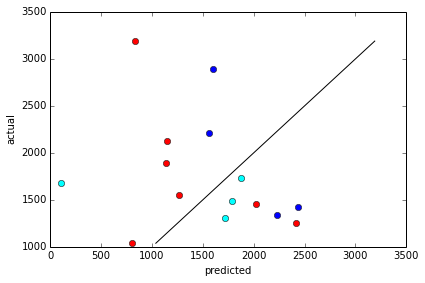

In [27]:
#fit regression model (using sklearn)
datafile = os.path.join('/Users/matar/Dropbox/PCA_elecs','brain_ROI.mat')
data = loadmat(datafile)
brain_ROI = data['brain_ROI']

X = hstack([latencies, peakvals, means, sums])
y = RT4
y = y.reshape((y.shape[0],-1)) #add dimension
clf = linear_model.RidgeCV(alphas = [0.1, 1, 10, 100, 1000])
betas = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

for train, test, in LeaveOneOut(len(y_train)):
    xtrain, xtest, ytrain, ytest = X_train[train], X_train[test], y_train[train], y_train[test]
    
    clf.fit(xtrain, ytrain)
    betas.append(clf.coef_.squeeze())

    yp = clf.predict(xtest)
    
    #plot (with color based on ROI)
    e = active_elecs[test]
    roi = get_ROI(subj, e, brain_ROI)
    try:
        col = color_dict[roi]
    except:
        col = 'black' #if color_dict doesn't have this ROI or no ROI exists     
    
    plt.plot(yp, ytest,'o', c= col)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    
plt.plot(y, y,'k')
plt.tight_layout()

##need to calculate R2 on held out test set (X_test) compare to y_test)

Bootstrap betas

In [28]:
#bootstrap beta pvalues
betas = pd.DataFrame(betas)
niter = 1000
nfeatures = betas.shape[1] #peaks, sums, means, latencies per active electrode
ci = list()
num_samples = 5

for b in np.arange(nfeatures): #features
    (n, c) =  bootstrap(np.array(betas.iloc[:,b]), num_samples, niter, np.mean, 0.05)
    ci.append(c)

betas_means = np.array(betas).squeeze().mean(axis =0) #mean across folds for each feature

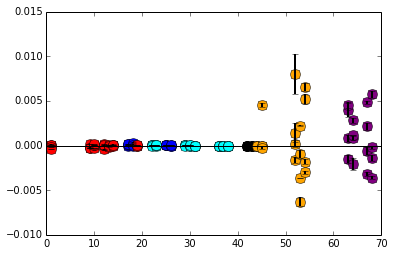

In [52]:
plt.errorbar(repeat(active_elecs,4), betas_means, yerr = (np.array(ci)[:,1] - np.array(ci)[:,0])/2, fmt = 'o', zorder = 1, markersize = 0, linewidth = 2, color = 'black')
plt.axhline(0, color='black')

for i, e in enumerate(repeat(active_elecs,4)): #color based on ROI
    roi = get_ROI(subj, e, brain_ROI)
    try:
        col = color_dict[roi]
    except:
        col = 'black' #if color_dict doesn't have this ROI or no ROI exists           
    plt.plot(e, betas_means[i],'o', c = col, zorder = 0, markersize= 10 ,label = roi)

Create groupidx_withROI csv - by reading in groupidx csv and running get_ROIs

In [69]:
datafolder = '/Users/matar/Dropbox/PCA_elecs/'
filename = 'brain_ROI.mat'
filename = os.path.join(datafolder, filename)
#brain_ROI = spio.loadmat(filename, struct_as_record = False, squeeze_me = True)['brain_ROI']
data = loadmat(filename)
brain_ROI = data['brain_ROI']


filename = 'groupidx.csv'
filename = os.path.join(datafolder, filename)
df = pd.DataFrame.from_csv(filename,index_col = [0,1])
filename

'/Users/matar/Dropbox/PCA_elecs/groupidx.csv'

In [94]:
## add ROI to each row of df based on active elec 
df['roi'] = ''
rows = list()

for index, row in df.iterrows():
    try:
        #rois = getattr(brain_ROI, index) #for use with struct
        rois = brain_ROI[index[0]] #all ROIs for this subject
    except:
        continue # this subject doesn't have ROIs done
        
    for roi in rois.keys(): #rois._fieldnames: #elecs per ROI
        #elecs=getattr(rois, field)
        elecs = rois[roi]
        
        if type(elecs) == int:
            elecs = [elecs]
        
        for e in elecs:
            if e == row['active elec']:
                row['roi'] = roi
                rows.append(row) 

In [273]:
#make dataframe
df_clusters = pd.DataFrame(rows)
filename = 'groupidx_withROI.csv'
filename = os.path.join(datafolder, filename)
pd.DataFrame.to_csv(df_clusters, filename)

#split up tuple index into subj, task separate columns, index on subjs
df_clusters['task'] = [x[1] for x in list(df_clusters.index)]
df_clusters['subj'] = [x[0] for x in list(df_clusters.index)]
df_clusters = df_clusters.set_index('subj') 

Combine grouping/cluster information with duration information

In [278]:
filename = os.path.join(datafolder,'dur_fdr_withROI_withactive.csv')
df_dur = pd.DataFrame.from_csv(filename)
#rename columns
df_dur.columns = ['task','active elec', 'is duration', 'roi','R value', 'pthresh', 'pvalues', 'pval adj']

In [279]:
#merge the data frames
df_cluster_dur = df_clusters.set_index(['task', 'active elec','roi'], append=True).join(df_dur.set_index(['task', 'active elec','roi'], append=True), how='outer')
df_cluster_dur.index.names = ['subj', 'task', 'active_elec', 'roi']
df_cluster_dur = df_cluster_dur.reset_index()

In [280]:
filename = os.path.join(datafolder,'groupidx_withROI_withduration.csv')
pd.DataFrame.to_csv(df_cluster_dur,filename)
filename

'/Users/matar/Dropbox/PCA_elecs/groupidx_withROI_withduration.csv'

In [283]:
brain_ROI['JH6']

{'ATL': array([ 1,  2,  3,  4,  9, 10, 11, 12, 17, 18], dtype=uint8),
 'Area_37': array([49, 57, 58], dtype=uint8),
 'Broca': array([ 5,  6,  7,  8, 14, 15, 16, 23], dtype=uint8),
 'IPL': array([53, 54, 61, 62, 63], dtype=uint8),
 'ITG': array([25, 26, 33, 34, 41], dtype=uint8),
 'MFG': 24,
 'MTG': array([19, 27, 35, 42, 43, 50, 51, 59], dtype=uint8),
 'Post_centrl': array([38, 47, 55, 56, 64], dtype=uint8),
 'Pre_centrl': array([13, 22, 30, 31, 32, 39, 40, 46, 48], dtype=uint8),
 'STG': array([20, 21, 28, 29, 36, 37, 44, 45, 52, 60], dtype=uint8)}

NOT USED and Troubleshooting code  
Calculate latency vs RTs (normalized RTs per cluster) - not used currently

In [139]:
#calc latency vs rts plus offset (normalized RTs per cluster)
SJdir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/'
datadir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/Subjs'
savedir = '/Users/matar/Dropbox/PCA_elecs/latencies/'
for i in np.arange(len(lines)):
#for i in [-1]:
    [subj, task] = lines[i].split('_')
    
    filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
    data = spio.loadmat(filename, struct_as_record = True)
    active_elecs = data['active_elecs'].squeeze()
    RTs = data['RTs'].squeeze()
    srate = data['srate']
    data = data['data_percent']
    
    cluster = df['group'][subj][task]
    active = df['active elec'][subj][task]
    
    for g, c in enumerate(active.groupby(cluster)): #active elecs per cluster
        #if g != 1:
        #    continue
        c = c[1].values
        cidx = np.in1d(active_elecs, c)
        cdata = data[cidx,:,:]
        cdata = np.vstack([item for item in cdata]) #same thing as cdata.reshape([-1,2783]); gives you trials x time

        RTs_all = tile(RTs, len(c)) #repmat RTs and sort
        ridx = RTs_all.argsort() 
        RTs_all.sort()
        
        cdata = cdata[ridx,:] #trials sorted by RTs
        
        #take mean of every 4 trials and every 4 RTs
        total = cdata.shape[0]/4
        idx = np.hstack([tile(j,4) for j in np.arange(total)])
        cdata4 = pd.DataFrame(cdata)
        cdata4 = cdata4.groupby(idx[0:cdata4.shape[0]]).apply(mean)
        
        RT4 = pd.DataFrame(RTs_all)
        RT4 = RT4.groupby(idx[0:RT4.shape[0]]).apply(mean).squeeze()

        #calculate time to peak
        latencies_norm = cdata4.idxmax(axis = 1)/RT4
        
        # fit regression model
        res = ols(y=RT4, x=latencies_norm)
        offset = res.beta.intercept
        pval = res.f_stat['p-value']
        offset = res.beta.intercept
        beta = res.beta['x']
                
        #plot
        figure(figsize=(10, 10), facecolor='w', edgecolor='k')
        plt.subplot(221)
        plt.autoscale(enable = True, tight = True)
        plt.imshow(cdata4, aspect='auto', origin='lower',interpolation = 'nearest',zorder = 0, vmin = -150, vmax = 150)
        plt.plot(RT4, np.arange(len(RT4)),'k.')
        title("%s %s cluster %i, grouped trials" %(subj, task, g))

        plt.subplot(222)
        plt.autoscale(enable = True, tight = True)
        plt.plot(RT4/RT4,np.arange(len(RT4)),'k.')
        plt.plot(latencies_norm,np.arange(len(RT4)),'g.')
        xlabel('RT-normalized time')
        ylabel('trials')
        title("HG peak latencies - normalized by RT")

        plt.subplot(223)
        iqr = np.percentile(latencies_norm, [25, 75])
        iqr = max(iqr)-min(iqr)
        binsize = 2 * iqr * (len(latencies_norm)**-1/3) #Freedman–Diaconis rule
        nbins = (max(latencies_norm)-min(latencies_norm))/binsize
        n, bins, patches = plt.hist(latencies_norm, bins = nbins, normed=0)
        h = plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
        xlabel("latencies")
        ylabel("count")
        
        plt.subplot(224)
        plt.scatter(latencies_norm, RT4,s = 20)
        plt.hold(True)
        x = np.array([min(latencies_norm), max(latencies_norm)])
        y = offset + beta * x
        plt.plot(x,y,'r')
        title("offset %dms, slope %0.2f, pval %f" %(offset, beta, pval))
        xlabel('normalized latencies')
        ylabel('RTs')
        
        filename = os.path.join(savedir, ''.join([lines[i], '_c', str(g+1), '_norm.png']))
        plt.savefig(filename)  
        plt.close()


KeyboardInterrupt: 

Troubleshooting

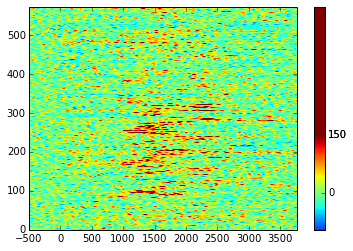

In [416]:
##TEST CLUSTERS
datadir = '/Users/matar/cluster/MATLAB/DATA/Avgusta/Subjs'
savedir = '/Users/matar/Dropbox/PCA_elecs/singletrials/'
#for i in np.arange(len(lines)):
for i in [37]:
    [subj, task] = lines[i].split('_')
    
    filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
    data = spio.loadmat(filename, struct_as_record = True)
    active_elecs = data['active_elecs'].squeeze()
    RTs = data['RTs'].squeeze()
    srate = data['srate']
    data = data['data_percent']
    
    cluster = df['group'][subj][task]
    active = df['active elec'][subj][task]
    
    c = active.groupby(cluster) #active elecs per cluster
    c = list(c)[4][1].values  #5th cluster  
    
    cidx = np.in1d(active_elecs, c)
    cdata = data[cidx,:,:]
    
    cdata = np.vstack([item for item in cdata]) #same thing as cdata.reshape([-1,2783]); gives you trials x time
    
    #ridx = RTs.argsort() 
    #RTs.sort()
    #RTs_all = tile(RTs, len(c)) #repmat RTs and sort
    #ridx = tile(ridx, len(c))
   
    #cdata = cdata[ridx,:] #trials sorted by RTs (each cluster kept together)
    
    f,ax = plt.subplots()
    ax.autoscale(enable = True, tight = True)
    cax = ax.pcolormesh(np.arange(-500, cdata.shape[1]-500), np.arange(0, cdata.shape[0]), cdata, zorder = 0)
    cbar = f.colorbar(cax, ticks = [150, 0 , 150], orientation = 'vertical')
    cbar.set_clim(vmin=-150,vmax=150) 
    
    #for j in ridx:
    #    ax.plot((RTs_all[j], RTs_all[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)      
    
#    filename = os.path.join(savedir, ''.join([lines[sid], '_e', str(elec), '_unsorted_separate.png']))
#    plt.savefig(filename)  
#    plt.close()



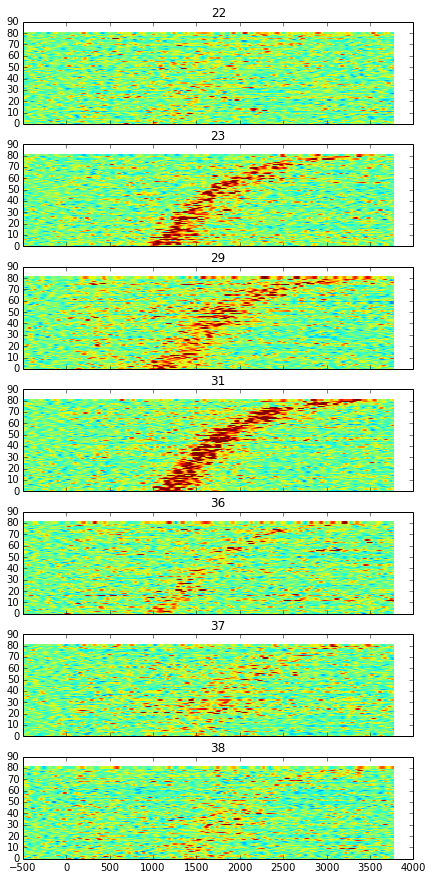

In [426]:
#PLOT SPECIFIC CLUSTER
filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
data = spio.loadmat(filename, struct_as_record = True)
active_elecs = data['active_elecs'].squeeze()
RTs = data['RTs'].squeeze()
data = data['data_percent']

clust = 5
c = list(active.groupby(cluster))
c = c[clust -1][1].values

cidx = np.in1d(active_elecs, c)
cdata = data[cidx,:,:]
ridx = RTs.argsort() 
RTs.sort()

f,axarr = plt.subplots(np.sum(cidx), sharex = True, figsize=(7, 15))

for i in np.arange(cdata.shape[0]):
    tmpdata = cdata[i,ridx,:]
    
    ax.autoscale(enable = True, tight = True)
    cax = axarr[i].pcolormesh(np.arange(-500, tmpdata.shape[1]-500), np.arange(0, tmpdata.shape[0]), tmpdata, zorder = 0,vmin = -150, vmax = 150)
    #cbar = f.colorbar(cax, ticks = [-1.5, 0 , 1.5], orientation = 'vertical')
    #cbar.set_clim(vmin=-1.5,vmax=1.5) #bc forgot to multiply by 100
    axarr[i].set_title(str(active_elecs[cidx][i]))

    for j in ridx:
        ax.plot((RTs[j], RTs[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)

#filename = os.path.join(savedir, ''.join([lines[sid], '_c', str(clust), '_elecs_sorted.png']))
#plt.savefig(filename)  
#plt.close()
#filename

In [40]:
# plot single electrode
elec = 62
sid = 44; #subj/task

datadir = '/Users/matar/cluster/MATLAB/DATA/Avgusta/Subjs'
savedir = '/Users/matar/Dropbox/PCA_elecs/singletrials/'
for i in [sid]: #subj/task
    [subj, task] = lines[i].split('_')
    
    filename = os.path.join(datadir, subj, task, 'HG_elecMTX_percent.mat')
    data = spio.loadmat(filename, struct_as_record = True)
    active_elecs = data['active_elecs'].squeeze()
    RTs = data['RTs'].squeeze()
    srate = data['srate']
    data = data['data_percent']
    
    cluster = df['cluster'][subj][task]
    active = df['active elec'][subj][task]
    
    eidx = np.in1d(active_elecs, elec)
    
    edata = data[eidx,:,:].squeeze() #trial x time
    ridx = RTs.argsort() 
    RTs.sort()

    edata = edata[ridx,:] #trials sorted by RTs
        
    #plot
    
    f,ax = plt.subplots()
    ax.autoscale(enable = True, tight = True)
    cax = ax.pcolormesh(np.arange(-500, edata.shape[1]-500), np.arange(0, len(ridx)), edata, zorder = 0, vmin = -1.5, vmax = 1.5)
    cbar = f.colorbar(cax, ticks = [-1.5, 0 , 1.5], orientation = 'vertical')
    cbar.set_clim(vmin=-1.5,vmax=1.5) #bc forgot to multiply by 100
    #plt.clim(-1.5,1.5)

    for j in ridx:
        ax.plot((RTs[j], RTs[j]), (j-0.5, j+0.5), 'k', linewidth = 3,zorder = 1)
            
    filename = os.path.join(savedir, ''.join([lines[sid], '_e', str(elec), '.png']))
    plt.savefig(filename)  
    plt.close()
        

In [692]:
### don't use - works but is clunky (for creating the csv file)
rows = list()
#add ROI to each row of df based on active elec 
for index, row in df.iterrows():
    try:
        rois = getattr(brain_ROI, index[0]) #all ROIs for this subject
    except:
        #print index[0]
        continue # this subject doesn't have ROIs done
        
    for field in rois._fieldnames: #elecs per ROI
        elecs=getattr(rois, field)
        
        if type(elecs) == int:
            elecs = [elecs]
        
        for e in elecs:
            if e == row['active elec']:
                row['roi'] = field
                rows.append(row)
                
tmp = pd.DataFrame([[row.name[0], row.name[1], row['active elec'], row['cluster'], row['roi']] for row in rows], columns = ['subj','task', 'active','cluster','roi'])
datafolder = '/Users/matar/Dropbox/PCA_elecs/'
filename = 'cluster_index_simple_withROI.csv'
filename = os.path.join(datafolder, filename)
pd.DataFrame.to_csv(tmp, filename)